In [1086]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1087]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

from lib.xedt import XEDT, Loss

In [1088]:
if 'experiment_name' not in globals():
    from evclust.ecm import ecm

    folder_figs = None

    df = pd.read_csv('data/three_clusters2D_synth.csv')
    feature_names = df.columns[:-1].to_list()
    features = df.iloc[:, :-1].values

    number_clusters = 3
    full_model = ecm(x=features, c=number_clusters, alpha=0.5, beta = 1.8, delta=10, disp=False, type='full')
    simple_model = ecm(x=features, c=number_clusters, alpha=0.5, beta = 1.8, delta=10, disp=False, type='simple')
    rough_model = ecm(x=features, c=number_clusters, alpha=1, beta = 1.01, delta=10, disp=False, type='full')

    # model_names : (mass, F, lambda_num)
    masses_to_test = {
        'full': (full_model['mass_n'], full_model['F'][1:], 1),
        'simple': (simple_model['mass_n'], simple_model['F'][1:], 0.5),
        'rough': (rough_model['mass_n'], rough_model['F'][1:], 1)
    }
features_dimension = features.shape[1]

if 'cmap' not in globals():
    cmap = 'Set1'

/Users/victor/Documents/GitHub/iemm/.venv/lib/python3.9/site-packages/evclust/ecm.py:121: RuntimeWarning: overflow encountered in power
  vect1 = (np.tile(D[i, j], f-1) / vect0) ** (1 / (beta-1))
/Users/victor/Documents/GitHub/iemm/.venv/lib/python3.9/site-packages/evclust/ecm.py:123: RuntimeWarning: overflow encountered in multiply
  vect3 = vect1 * vect2


In [1089]:
def get_style(F, cmap):    
    number_metaclusters = len(F)
    number_clusters = len(F[0])
    cmap = plt.get_cmap(cmap)
    
    if number_clusters == 3 and cmap.name == 'Pastel1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(0))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([1, 1, 1, 1])
    if number_clusters == 3 and cmap.name == 'Set1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([0.9, 0.9, 0.9, 1])
    else:
        cluster_base_colors = [np.array(cmap(i)) for i in range(len(F))]
        cardinality_indication_color = np.array(cmap(number_metaclusters))
    focal_colors = []

    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i]
        color = color/np.sum(f)

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]
    
    # formatting focal sets for printing
    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(number_clusters)]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    return focal_colors, focal_sets, mass_focal_sets

In [1090]:
def get_centroids(F, masses):
    """
    Compute the centroids of the clusters based on the focal sets and their masses.
    """
    metacluster_centroids = []
    for i in range(len(F)):
        if np.sum(F[i]) > 0:
            centroid = np.zeros(features.shape[1])
            for point in range(features.shape[0]):
                centroid += features[point] * masses[point, i]
            centroid /= np.sum(masses[:, i])
            metacluster_centroids.append(centroid)
    metacluster_centroids = np.array(metacluster_centroids)

    return metacluster_centroids

In [1091]:
def get_colors(focal_colors, masses):    
    colors = []
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * masses[point, i] for i in range(len(focal_colors))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    return colors

In [1092]:
def explore_iemm(mass, F, model_name, lambdas, ax=None):
    # getting the colorscheme and focal sets names
    focal_colors, focal_sets, mass_focal_sets = get_style(F, cmap=cmap)

    diagram_args = {
        'class_names' : mass_focal_sets,
        'cluster_names' : focal_sets,
        'feature_names' : feature_names,
    }
    
    if not ax is None:
        diagram_args['focal_colors'] = focal_colors

        # getting centroids
        metacluster_centroids = get_centroids(F, mass)

        # getting each point color
        colors = get_colors(focal_colors, mass)

        # plotting points
        ax[0].set_title(f"$\mathcal{{M}}_{{{model_name}}}$")
        for i in range(len(features)):
            ax[0].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
        # informing the legend
        for i in range(len(focal_sets)):
            ax[0].scatter([], [], color=focal_colors[i], label=focal_sets[i])
        # plot centroids
        for i in range(len(metacluster_centroids)):
            ax[0].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        # remove ticks
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # get the limits
        xmin, xmax = ax[0].get_xlim()
        ymin, ymax = ax[0].get_ylim()

    diagrams, paths, pred_metaclusters, all_metaclusters = {}, {}, {}, {}
    idx_img = 0
    for lambda_mistakeness in lambdas:
        # goes to next plot
        idx_img += 1

        # getting the IEMM classifier
        classifier = XEDT(lambda_mistakeness=lambda_mistakeness)

        y = mass.copy()
        classifier.fit(features, y, F)
        diagram = classifier.plot_tree(
            **diagram_args
        )
        diagrams[lambda_mistakeness] = diagram

        pred_metaclusters[lambda_mistakeness] = classifier.predict_metacluster(features).reshape(-1)

        # getting the path (that is, the explanation) for each metacluster
        path = classifier.get_path(['x','y'], focal_sets)
        paths[lambda_mistakeness] = path
        # saving the diagram
        if folder_figs is not None:
            os.makedirs(f'{folder_figs}/xedt_outs_{model_name}', exist_ok=True)
            diagram.save(f'{folder_figs}/xedt_outs_{model_name}/diagram_{lambda_mistakeness}.pdf')

        if not ax is None:
            # plotting the regions
            X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
            features_xy = np.column_stack((X.ravel(), Y.ravel()))
            Z_metclus = classifier.predict_metacluster(features_xy).reshape(X.shape[0], X.shape[1], -1)
            Z_color = np.zeros((X.shape[0], X.shape[1], 3))
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z_color[i, j] = focal_colors[Z_metclus[i, j, 0]][:3]
            ax[idx_img].imshow(Z_color, extent=(xmin, xmax, ymin, ymax), origin='lower')

            # defining the title
            if lambda_mistakeness == np.inf:
                title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
            else:
                title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
            ax[idx_img].set_title(title)
            # defining the limits
            ax[idx_img].set_xticks([])
            ax[idx_img].set_yticks([])
            # scatter the data
            for i in range(len(features)):
                ax[idx_img].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
            # plot centroids
            for i in range(len(metacluster_centroids)):
                ax[idx_img].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        
    # paths to df
    paths_df = pd.DataFrame()
    for lambda_mistakeness in paths.keys():
        path = paths[lambda_mistakeness]
        p = {}
        for d in path:
            for k, v in d.items():
                p.setdefault(k, []).append(v)
        df = pd.DataFrame(p)
        if lambda_mistakeness == np.inf:
            title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
        else:
            title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
        df.index = [title]
        paths_df = pd.concat([paths_df, df])        

    return paths_df, diagrams, pred_metaclusters

In [1093]:
def evaluate(mass, pred_metaclusters, F, lambda_):
    okness = 0
    for point in range(len(pred_metaclusters)):
        den = 0
        okness1 = 0
        for metacluster in range(len(F)):
            S = Loss.S(F[metacluster], F[pred_metaclusters[point]], lambda_)
            okness1 += mass[point, metacluster] * S
            den += S
        okness += okness1
    return okness / mass.shape[0]

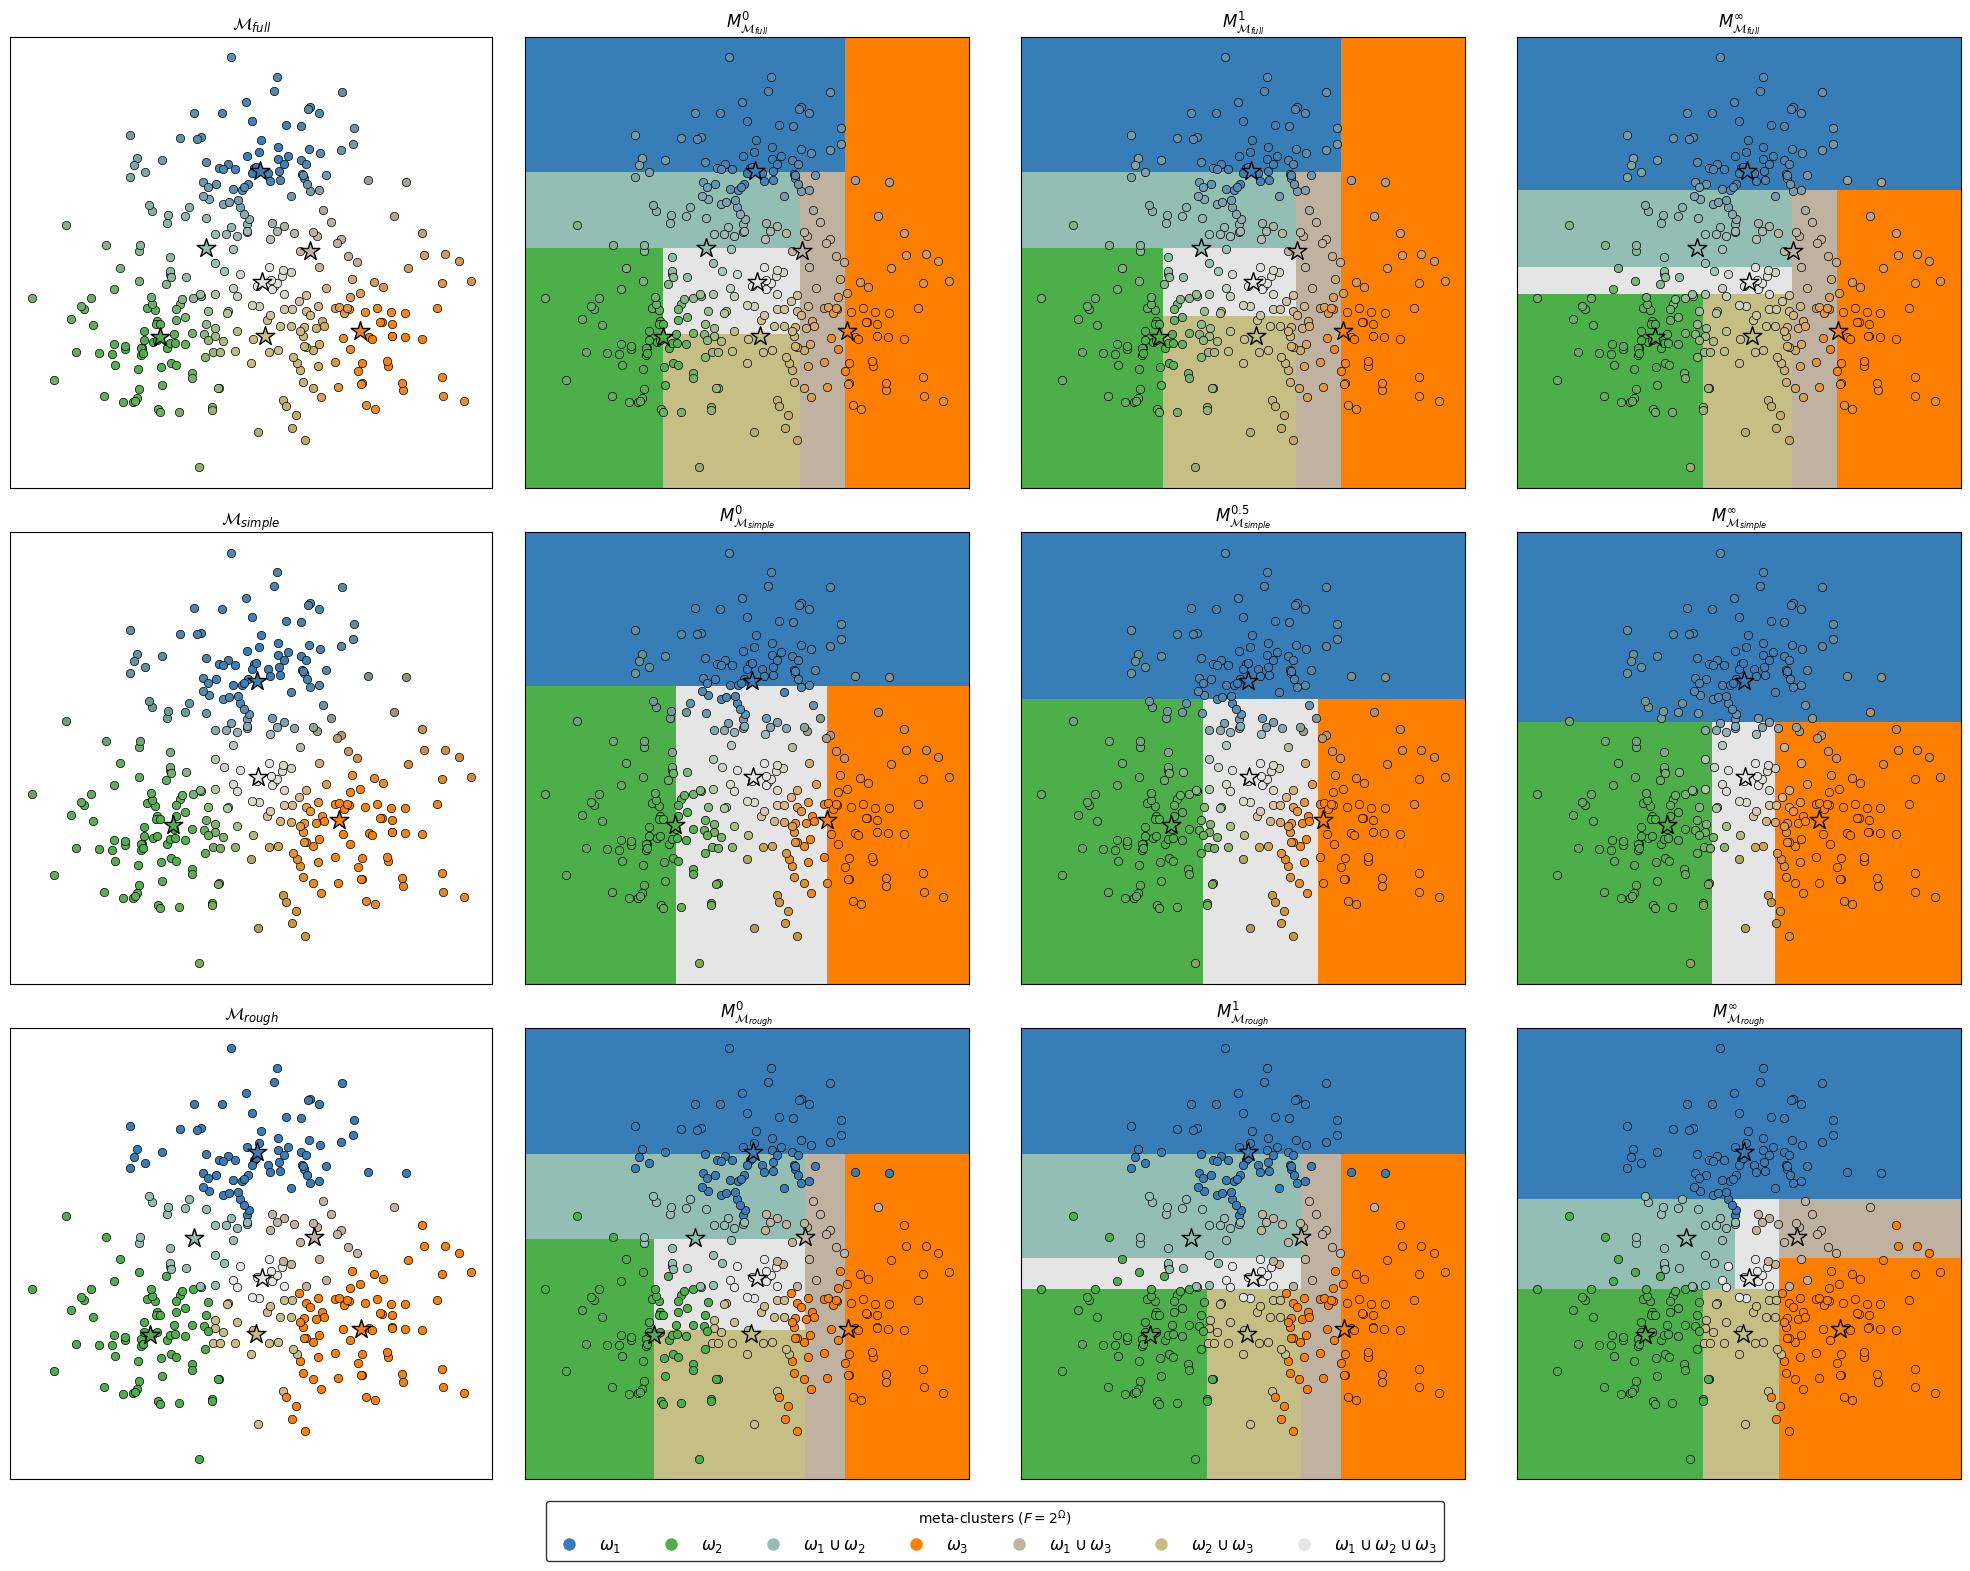

{'full_0': 0.25121530557661687,
 'full_1': 0.20233358449142402,
 'full_inf': 0.05484590356192587,
 'simple_0': 0.26333535165286603,
 'simple_0.5': 0.13678390729183132,
 'simple_inf': 0.004698267098823705,
 'rough_0': 0.47325082624142223,
 'rough_1': 0.29033073815700994,
 'rough_inf': -0.003936074903219122}

In [1094]:
if features_dimension == 2:
    fig, ax = plt.subplots(len(masses_to_test), 4, figsize=(20, 5*len(masses_to_test)))

i = 0
scores = {}
for model_name, (mass, F, lambda_num) in masses_to_test.items():
    # test the model for different lambda values
    all_lambdas = [0, lambda_num, np.inf]

    if features_dimension == 2:
        ax_ = ax[i, :]
    else:
        ax_ = None

    paths_df, diagrams, pred_metaclusters = explore_iemm(mass, F, model_name, all_lambdas, ax=ax_)
    i += 1

    # test imm for the model
    mass_saturated = np.zeros(mass.shape)
    max_mass = np.argmax(mass, axis=1)
    for j in range(mass.shape[0]):
        mass_saturated[j, max_mass[j]] = 1
    _, _, pred_imm = explore_iemm(mass_saturated, F, model_name + '_IMM', [np.inf])

    for lambda_ in all_lambdas:
        score = evaluate(mass, pred_metaclusters[lambda_], F, lambda_)
        score_imm = evaluate(mass, pred_imm[np.inf], F, lambda_)
        scores[f'{model_name}_{lambda_}'] = 1 - score/score_imm

if features_dimension == 2:
    focal_colors, focal_sets, mass_focal_sets = get_style(F, cmap=cmap)
    lgd = fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], markerfacecolor=focal_colors[i], markersize=10) for i in range(len(focal_sets))]
                                ,edgecolor='black', loc='lower center', ncol=len(focal_sets), fontsize='large', title='meta-clusters ($F = 2^\Omega$)', bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout()
    plt.show()

scores

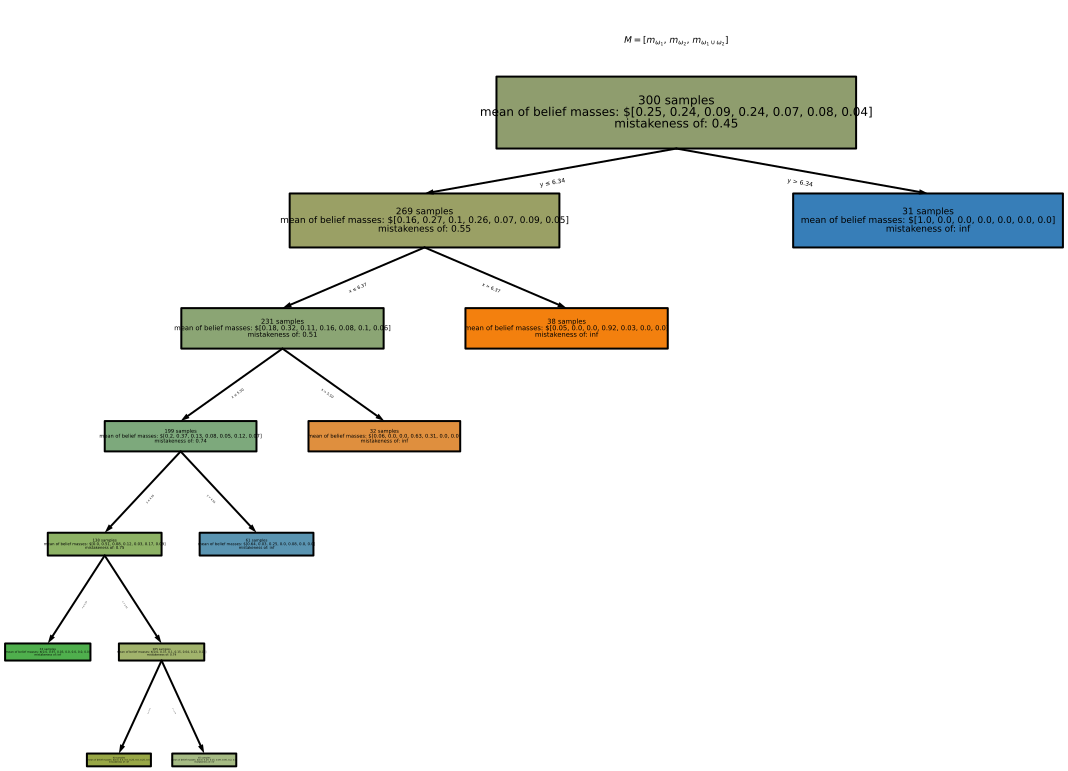

In [1095]:
diagrams[0]

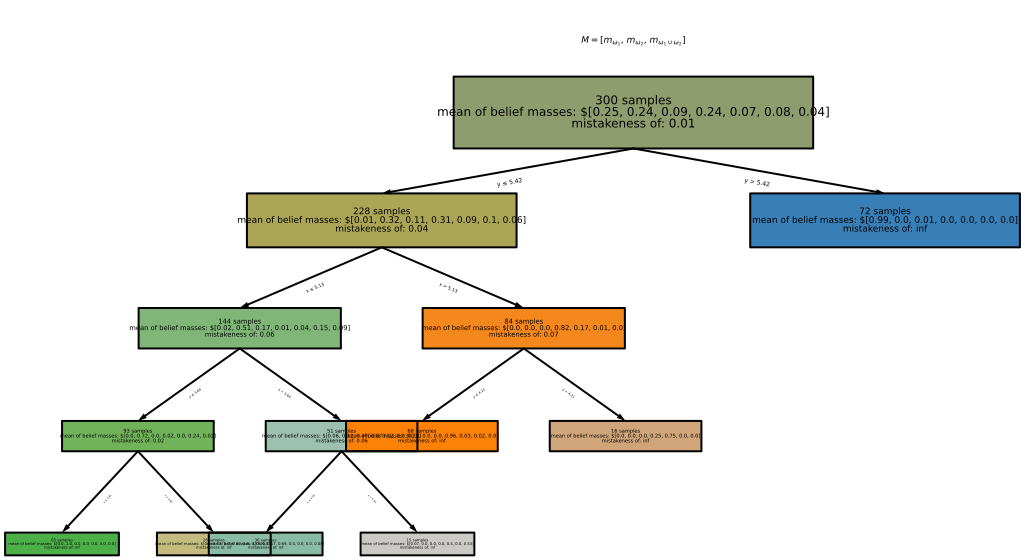

In [1096]:
diagrams[np.inf]